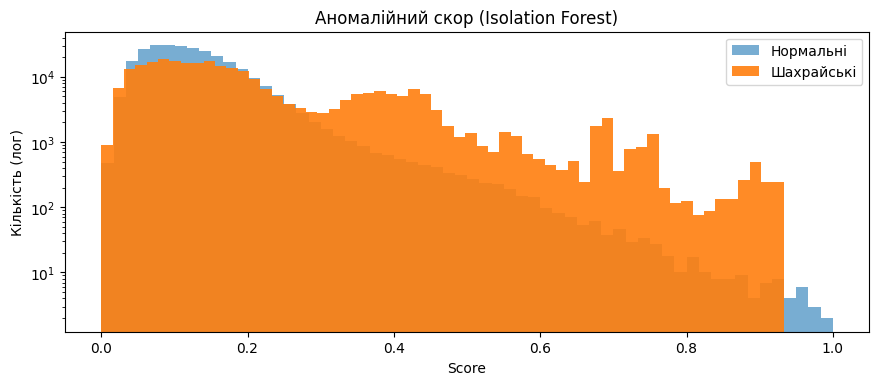

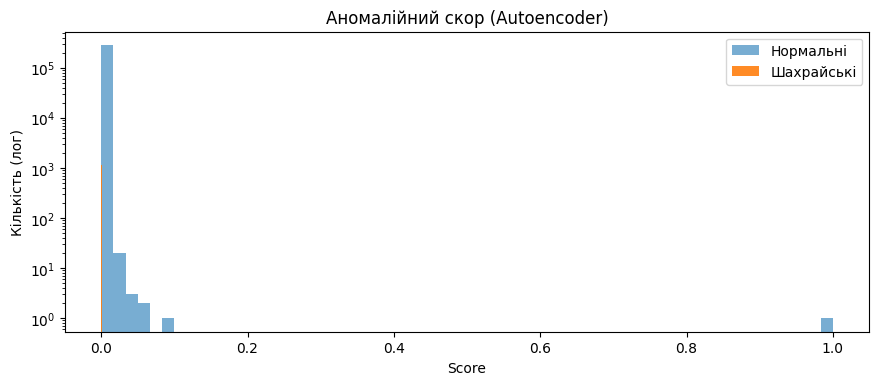

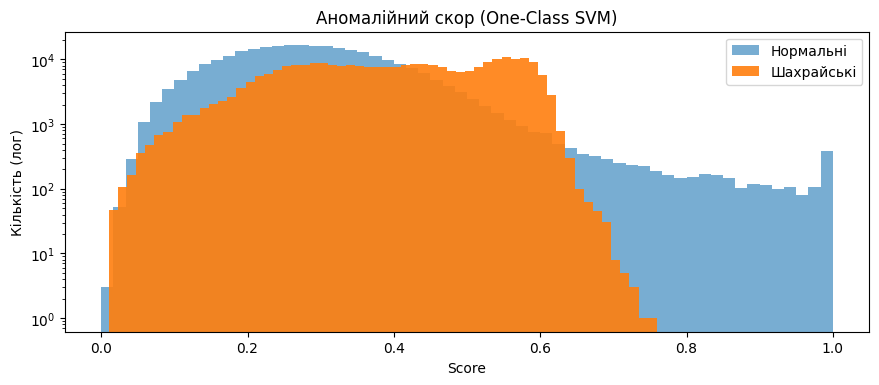

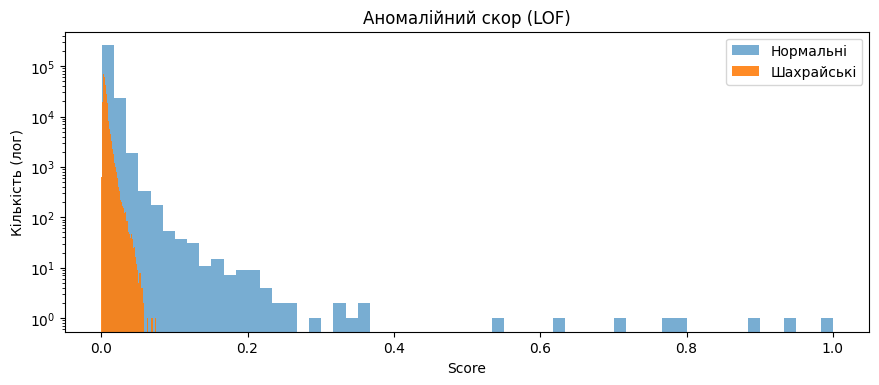

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, filedialog, messagebox


# Precision/Recall @ Threshold
def precision_recall_at_k(y_true, scores, threshold=0.95):
    y_pred = (scores >= threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall, y_pred


# Теоретичний опис моделей
MODEL_DESCRIPTIONS = {
    "Isolation Forest": "Isolation Forest: будує ліс випадкових дерев і виділяє аномалії за глибиною ізоляції.",
    "Autoencoder": "Autoencoder: нейромережа, яка реконструює вхідні дані; аномалії мають високу reconstruction error.",
    "One-Class SVM": "One-Class SVM: вчить межу для нормальних даних, аномалії – поза цією межею (на підвибірці для стабільності).",
    "LOF": "Local Outlier Factor: оцінює аномалії на основі локальної щільності сусідів (на підвибірці для стабільності)."
}

# Логування
class Logger:
    def __init__(self):
        self.logs = []

    def log(self, method, transaction_idx, score, reason=""):
        self.logs.append({
            "method": method,
            "transaction_idx": transaction_idx,
            "score": score,
            "reason": reason
        })

    def get_logs(self):
        return pd.DataFrame(self.logs)

logger = Logger()


# Fraud Detector
class FraudDetector:
    def __init__(self, df, progress_callback=None, threshold=0.95, batch_size=5000):
        self.df = df.copy()
        self.progress_callback = progress_callback
        self.threshold = threshold
        self.batch_size = batch_size
        self.y = df["Class"].values if "Class" in df.columns else None

        self.features = [f"V{i}" for i in range(1,29)] + ['Amount']
        self.X = self.df[self.features].values

        # Масштабування
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)

        # Обробка дисбалансу (oversampling)
        if self.y is not None and np.mean(self.y) < 0.05:
            smote = SMOTE(sampling_strategy=0.1, random_state=42)
            self.X_scaled, self.y = smote.fit_resample(self.X_scaled, self.y)

    # Isolation Forest
    def isolation_forest(self):
        model = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
        model.fit(self.X_scaled)
        scores = -model.score_samples(self.X_scaled)
        scores = (scores - scores.min()) / (scores.max() - scores.min())
        if self.progress_callback:
            self.progress_callback(100)

        top_idx = np.argsort(scores)[::-1][:5]
        for i in top_idx:
            logger.log("Isolation Forest", i, scores[i], reason="High anomaly score")
        return scores, self.y

    # Autoencoder
    def autoencoder(self):
        X_tensor = torch.tensor(self.X_scaled, dtype=torch.float32)
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        class AutoEncoder(nn.Module):
            def __init__(self, input_dim):
                super().__init__()
                self.encoder = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, 8))
                self.decoder = nn.Sequential(nn.Linear(8, 32), nn.ReLU(), nn.Linear(32, input_dim))
            def forward(self, x):
                return self.decoder(self.encoder(x))

        model = AutoEncoder(X_tensor.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        epochs = 10
        total_steps = epochs * len(loader)
        step = 0

        for epoch in range(epochs):
            for (batch,) in loader:
                optimizer.zero_grad()
                recon = model(batch)
                loss = criterion(recon, batch)
                loss.backward()
                optimizer.step()
                step += 1
                if self.progress_callback:
                    self.progress_callback(int(step/total_steps*100))

        with torch.no_grad():
            recon_all = model(X_tensor)
            scores = torch.mean((X_tensor - recon_all) ** 2, dim=1).numpy()
            scores = (scores - scores.min()) / (scores.max() - scores.min())

        top_idx = np.argsort(scores)[::-1][:5]
        for i in top_idx:
            logger.log("Autoencoder", i, scores[i], reason="High reconstruction error")

        if self.progress_callback:
            self.progress_callback(100)
        return scores, self.y

    # One-Class SVM (subsample)
    def one_class_svm(self):
        subsample_size = min(20000, len(self.X_scaled))
        idx = np.random.choice(len(self.X_scaled), subsample_size, replace=False)
        X_sub = self.X_scaled[idx]

        model = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')
        model.fit(X_sub)

        scores = np.zeros(len(self.X_scaled))
        for start in range(0, len(self.X_scaled), self.batch_size):
            end = start + self.batch_size
            batch = self.X_scaled[start:end]
            scores[start:end] = -model.decision_function(batch)
            if self.progress_callback:
                self.progress_callback(int(end/len(self.X_scaled)*100))

        scores = (scores - scores.min()) / (scores.max() - scores.min())
        top_idx = np.argsort(scores)[::-1][:5]
        for i in top_idx:
            logger.log("One-Class SVM", i, scores[i], reason="High anomaly score")
        return scores, self.y

    # LOF (subsample)
    def lof(self):
        subsample_size = min(20000, len(self.X_scaled))
        idx = np.random.choice(len(self.X_scaled), subsample_size, replace=False)
        X_sub = self.X_scaled[idx]

        model = LocalOutlierFactor(n_neighbors=20, novelty=True)
        model.fit(X_sub)

        scores = np.zeros(len(self.X_scaled))
        for start in range(0, len(self.X_scaled), self.batch_size):
            end = start + self.batch_size
            batch = self.X_scaled[start:end]
            scores[start:end] = -model.decision_function(batch)
            if self.progress_callback:
                self.progress_callback(int(end/len(self.X_scaled)*100))

        scores = (scores - scores.min()) / (scores.max() - scores.min())
        top_idx = np.argsort(scores)[::-1][:5]
        for i in top_idx:
            logger.log("LOF", i, scores[i], reason="High anomaly score")
        return scores, self.y

# GUI
class App:
    def __init__(self, root):
        self.root = root
        root.title("Система виявлення шахрайських транзакцій")
        root.geometry("900x800")

        self.df = None

        tk.Button(root, text="📂 Завантажити CSV-файл", command=self.load_csv).pack(pady=5)

        self.method = ttk.Combobox(
            root, values=["Isolation Forest","Autoencoder","One-Class SVM","LOF"],
            state="readonly", width=30)
        self.method.set("Isolation Forest")
        self.method.pack(pady=5)

        tk.Button(root, text="▶ Запустити аналіз", command=self.run).pack(pady=5)

        self.progress = ttk.Progressbar(root, orient='horizontal', length=600, mode='determinate')
        self.progress.pack(pady=5)

        tk.Label(root, text="Threshold (для алертів, 0-1)").pack()
        self.threshold_var = tk.DoubleVar(value=0.95)
        tk.Entry(root, textvariable=self.threshold_var, width=10).pack()

        self.output = tk.Text(root, height=15, width=105)
        self.output.pack(pady=5)

        self.figure_frame = tk.Frame(root)
        self.figure_frame.pack(fill='both', expand=True)

    def load_csv(self):
        path = filedialog.askopenfilename(filetypes=[("CSV файли","*.csv")])
        if path:
            self.df = pd.read_csv(path)
            messagebox.showinfo("Готово", "Датасет успішно завантажено")

    def update_progress(self, value):
        self.progress['value'] = value
        self.root.update_idletasks()

    def run(self):
        if self.df is None:
            messagebox.showerror("Помилка", "Спочатку завантажте датасет")
            return

        threshold = self.threshold_var.get()
        detector = FraudDetector(self.df, progress_callback=self.update_progress, threshold=threshold)

        model_name = self.method.get()
        self.output.delete("1.0", tk.END)
        self.output.insert(tk.END, f"Модель: {model_name}\n")
        self.output.insert(tk.END, f"Опис: {MODEL_DESCRIPTIONS.get(model_name,'')}\n\n")

        if model_name == "Isolation Forest":
            scores, y_true = detector.isolation_forest()
        elif model_name == "Autoencoder":
            scores, y_true = detector.autoencoder()
        elif model_name == "One-Class SVM":
            scores, y_true = detector.one_class_svm()
        elif model_name == "LOF":
            scores, y_true = detector.lof()

        # Precision/Recall
        p, r, y_pred = precision_recall_at_k(y_true, scores, threshold=threshold)
        self.output.insert(tk.END, f"Threshold: {threshold:.2f}\n")
        self.output.insert(tk.END, f"Precision: {p:.4f}\nRecall: {r:.4f}\n")
        self.output.insert(tk.END, f"Top-підозрілі транзакції: {np.sum(y_pred)}\n")

        # Графік score
        for widget in self.figure_frame.winfo_children():
            widget.destroy()

        fig, ax = plt.subplots(figsize=(8,5))
        ax.hist(scores[y_true==0], bins=60, alpha=0.6, label="Нормальні")
        ax.hist(scores[y_true==1], bins=60, alpha=0.9, label="Шахрайські")
        ax.set_yscale("log")
        ax.set_title(f"Аномалійний скор ({model_name})")
        ax.set_xlabel("Score")
        ax.set_ylabel("Кількість (лог)")
        ax.legend()
        fig.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=self.figure_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill='both', expand=True)

        # Вивід логів топ-5
        self.output.insert(tk.END, "\nЛог топ-5 підозрілих транзакцій (за індексом):\n")
        logs_df = logger.get_logs()
        self.output.insert(tk.END, logs_df.head().to_string(index=False))

# Запуск GUI
root = tk.Tk()
app = App(root)
root.mainloop()